# Lab 2 (Part 1): Image classification with MLPs

**Jose Antonio Jijon Vorbeck - 100438045**


------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this second lab of the course, you will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
# pytorch package
import torch
# neural networks
from torch import nn
# optimizer
from torch import optim
import matplotlib.pyplot as plt
import math

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
# getting all the training data in a variable
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
# need to store this in a trainloder, that contains a list of  xtensors and y tensors
# batch size dictates how many items pass at each time, like training in small pieces
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
# we do the same for the testing data
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...





/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to **shuffle the dataset every time we start going through the data loader again**. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [4]:
# iter function creates an iterator 
# every element of this iterator contains 64 images of 1 color and 28by28 and label 
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

tensor(1)



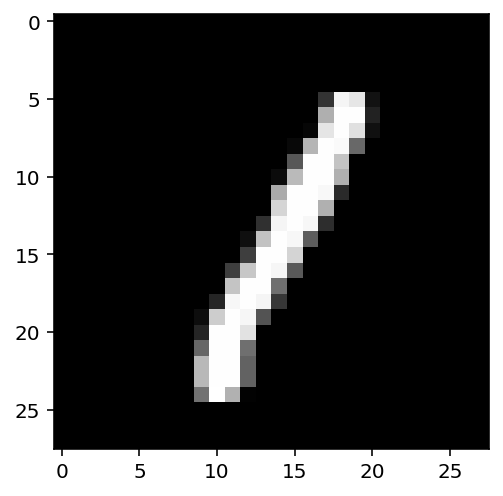

In [5]:
plt.imshow(images[0].view([28,28]), cmap='Greys_r')
print(labels[0])

## Part II. Train a multi-class Logistic Regressor

Our first goal is to train a multi-class logistic regressor to evaluate how good it can do in both the training and the test sets. 

The following code is **almost identical** to the one you used for Lab 1 except for two small details:

- We are training a LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid). 

- We are using the MNIST database loaded above.

We first define the Multi-class Logistic Regressor class

> **Exercise**: Complete the following code

In [6]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        # arguments passed for the first layer are: input and output 'neurons' 
        # dimx : dimension of x (28*28)
        # nlabels : number of digits we want to predict, so it must be 10
        self.output = nn.Linear(dimx,nlabels)

        self.logsoftmax = nn.LogSoftmax(dim=1)   # NEW w.r.t Lab 1. dim is the dimension along which 
                                                 #Softmax will be computed (so every slice along dim will sum to 1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.logsoftmax(x)

        return x

Note that we use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, we can use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor. 

> **Exercise**: Complete the following code

In [7]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        # pass same parameters than parent class
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!, 
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                # get output of last computed value
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)

                # Compute the loss with these values:
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                # now we compute the backward error of this:
                loss.backward()

                # finally we run the optimizer:
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Ok that was easy, wasn't it? Lets now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [8]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=10,lr=1e-3)

my_LR.train(trainloader)


Training loss after 0 epochs: 0.465543
Training loss after 1 epochs: 0.326697
Training loss after 2 epochs: 0.307561
Training loss after 3 epochs: 0.300417
Training loss after 4 epochs: 0.295096
Training loss after 5 epochs: 0.290175
Training loss after 6 epochs: 0.286855
Training loss after 7 epochs: 0.284655
Training loss after 8 epochs: 0.282790
Training loss after 9 epochs: 0.279769


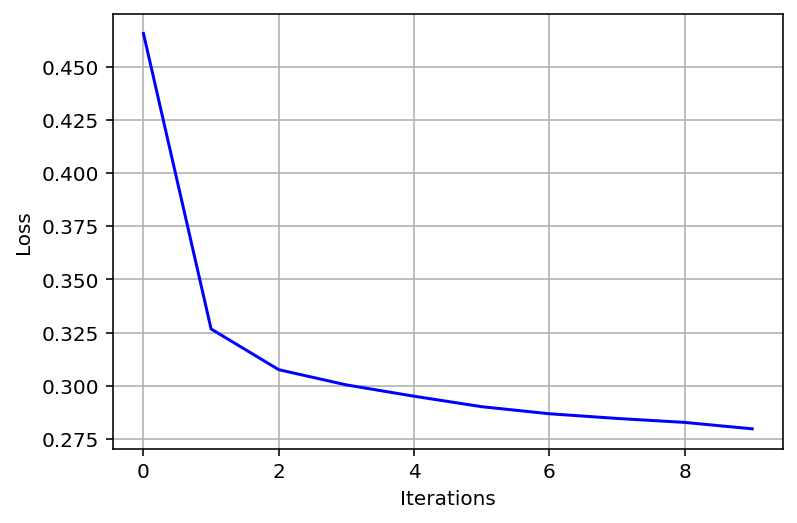

In [9]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [10]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:
        
        # We use a log-softmax, so what we get are log-probabilities
        logprobs = my_LR.forward(images.view(images.shape[0], -1)) 
        
        # get the top probability and class per image
        top_p, top_class = logprobs.topk(1, dim=1)
        # see if these values are the same (match with the groundtruth)
        equals = (top_class == labels.view(images.shape[0], 1))
        # if it does, then is 1, if not it is 0
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    

print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.920084


With the probabilities, we can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line 
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting werther `top_class` is equeal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean using `torch.mean()`.

> **Excercise** Modify the code of the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set (Use a single method with the proper inputs!). Compute the train/test accuracy using such a method.

In [11]:
#YOUR CODE HERE  
# modify the class Multi_LR_extended to add a new method 'performance' 
# it has to work in either the test or train sets
# copying the same class from before and modifying it:

class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        # pass same parameters than parent class
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!, 
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    
    def accuracy(self, loader):

        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

          for images,labels in loader:

              # We use a log-softmax, so what we get are log-probabilities
              logprobs = self.forward(images.view(images.shape[0], -1)) 

              # get the top probability and class per image
              top_p, top_class = logprobs.topk(1, dim=1)
              # see if these values are the same (match with the groundtruth)
              equals = (top_class == labels.view(images.shape[0], 1))
              # if it does, then is 1, if not it is 0
              accuracy += torch.mean(equals.type(torch.FloatTensor))

        print("Accuracy %f" %(accuracy/len(loader)))

    
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                # get output of last computed value
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)

                # Compute the loss with these values:
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                # now we compute the backward error of this:
                loss.backward()

                # finally we run the optimizer:
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


In [12]:
#YOUR CODE HERE    
# try out the method in this part
# performance of train
# performance of test
# dimension must be flat dimension 28*28
dimx = images[0].shape[1]*images[0].shape[1]
# instantiate the model
my_LR = Multi_LR_extended(dimx, 10, epochs=10)
# train it with the trainloader
my_LR.train(trainloader)

Training loss after 0 epochs: 0.465284
Training loss after 1 epochs: 0.325387
Training loss after 2 epochs: 0.310647
Training loss after 3 epochs: 0.300118
Training loss after 4 epochs: 0.296137
Training loss after 5 epochs: 0.292431
Training loss after 6 epochs: 0.286664
Training loss after 7 epochs: 0.285157
Training loss after 8 epochs: 0.282413
Training loss after 9 epochs: 0.280112


In [13]:
# now we test the accuracy with testing and training data:
# training data:
my_LR.accuracy(trainloader)
# testing data:
my_LR.accuracy(testloader)

Accuracy 0.916445
Accuracy 0.914908


Observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

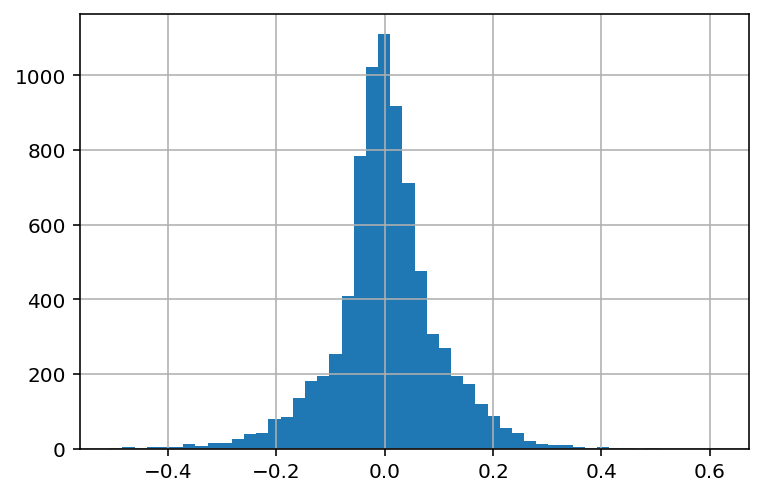

In [14]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50) # Modify my_LR by the name of the object you defined above
plt.grid()

In [15]:
# shape of the weights tensor:
my_LR.output.weight.shape
# we see that we have 10 rows (categories), and 784 columns, same as the 
# number of pixels we have per image ! 28x28

torch.Size([10, 784])

> **Exercise**: Plot the histogram of the gradients of the loss function w.r.t. every parameter in the model:

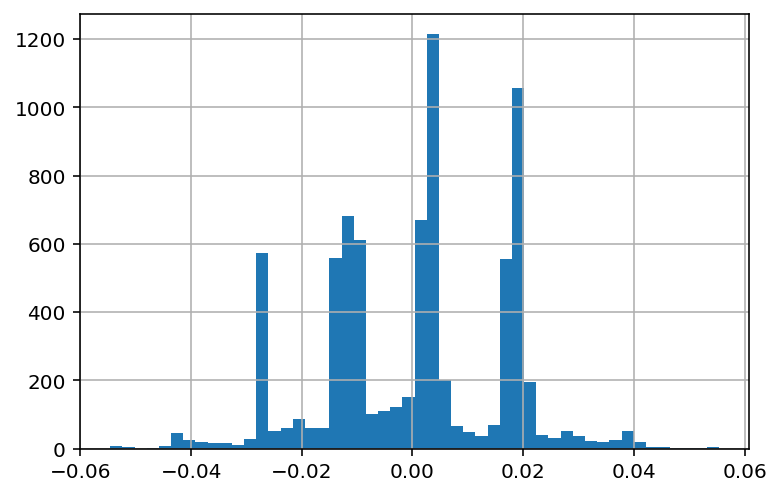

In [16]:
#YOUR CODE HERE
plt.hist(my_LR.output.weight.grad.view([-1,]),50)
plt.grid()
# we see that all gradients are between [-0.04,0.06], thus they are very small
# and close to zero actually

As we can see most of the gradients are almost zero

## Part III. Train a MLP to do the same job

Modify the code you have just implemented for a MLP is straightforward. Assume we want to train a MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer, that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [17]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=500, height=300)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.

> **Exercise**: Complete the code for the following class

In [18]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        # first layer
        self.output1 = nn.Linear(dimx,hidden1)
        
        # second layer (first hidden)
        self.output2 = nn.Linear(hidden1,hidden2)
        
        # third layer (second hidden)
        self.output3 = nn.Linear(hidden2,nlabels)

        # Rectified linear units as activation function
        self.relu = nn.ReLU()
        
        # log_softmax function as activation function for last layer
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        # layer 1
        x = self.output1(x)
        x = self.relu(x)
        # layer 2
        x = self.output2(x)
        x = self.relu(x)
        # layer 3
        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

> **Excercise** Create a class `MLP_extended` that incorporates two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the code you have done above for the multi-class LR. This is why I like class and structure my code this way!!

In [19]:
# now we create a child class that inherits from MLP
class MLP_extended(MLP):

    def __init__(self, dimx, hidden1, hidden2, nlabels, epochs=100,lr=0.001):
        
        # pass same parameters than parent class
        super().__init__(dimx, hidden1, hidden2, nlabels) 
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        
    
    def accuracy(self, loader):

        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

          for images,labels in loader:

              # We use a log-softmax, so what we get are log-probabilities
              logprobs = self.forward(images.view(images.shape[0], -1)) 

              # get the top probability and class per image
              top_p, top_class = logprobs.topk(1, dim=1)
              # see if these values are the same (match with the groundtruth)
              equals = (top_class == labels.view(images.shape[0], 1))
              # if it does, then is 1, if not it is 0
              accuracy += torch.mean(equals.type(torch.FloatTensor))

        print("Accuracy %f" %(accuracy/len(loader)))

    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:             
        
                self.optim.zero_grad() 
            
                # get output of last computed value
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)

                # Compute the loss with these values:
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                # now we compute the backward error of this:
                loss.backward()

                # finally we run the optimizer:
                self.optim.step()


            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Train the model for 10 epochs and compute the train/test performance. How does it compare with the Logistic Regressor?

In [20]:
# We initiate and train the model the same way as in the above parts:
# first we instantiate it:
# dimx = 28x28
dimx = images[0].shape[1]*images[0].shape[1]
my_MLP = MLP_extended(dimx, 128, 64, 10, epochs=10, lr= 1e-3)
# now we train it with the trainloader:
my_MLP.train(trainloader)

Training loss after 0 epochs: 0.389964
Training loss after 1 epochs: 0.185214
Training loss after 2 epochs: 0.132447
Training loss after 3 epochs: 0.108782
Training loss after 4 epochs: 0.090064
Training loss after 5 epochs: 0.078450
Training loss after 6 epochs: 0.071141
Training loss after 7 epochs: 0.065522
Training loss after 8 epochs: 0.060020
Training loss after 9 epochs: 0.055861


In [21]:
images[0].shape[1]*images[0].shape[1]

784

In [22]:
# now we get the performances of the models
# training set
my_MLP.accuracy(trainloader)
# testing set
my_MLP.accuracy(testloader)

Accuracy 0.989089
Accuracy 0.975617


Wow! Performace is almost perfect with a naive Neural Network!!

> **Exercise:** Lets visualize the activations at the ouput of the first layer for a minibatch test images. This will help to identify possible unused hidden units (allways activated/deactivated) and correlated hidden units, e.g. redundant units. Complete the following code.

(64, 128)

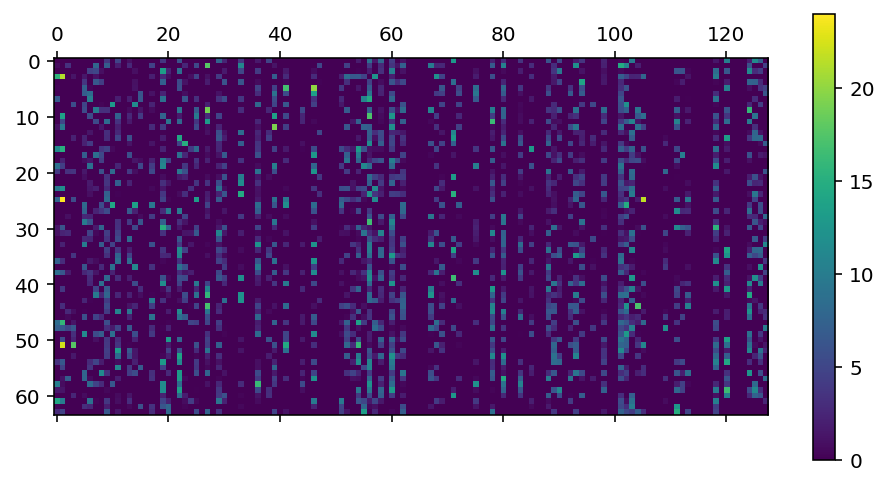

In [23]:
# First, we load a test minibatch

x_test,y_test = next(iter(testloader)) 

# Then, we evaluate the output of the first layer of the network for that mini-batch
# we must also apply the activation function and then detach it and convert it to numpy array
activations = my_MLP.relu(my_MLP.output1(x_test.view(x_test.shape[0],-1))).detach().numpy()

# We plot the matrix using matplotlib

plt.matshow(activations)

plt.colorbar()
# shape of the activations:
activations.shape

Based on the plot, do you think there are unsued hidden units in the hidden layer? They are characterize by units that are always active (very high values) or unactive (almost zero values). Plot the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units. 

There are 52 hidden units that are unactive


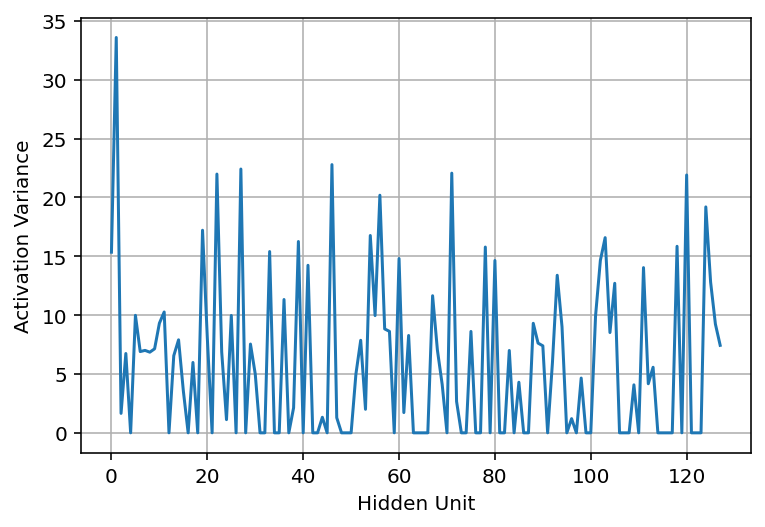

In [24]:
plt.plot(np.var(activations,0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

print("There are {0:d} hidden units that are unactive".format(np.sum(np.var(activations,0)<=0.1)))
unactive = np.sum(np.var(activations,0)<=0.1)

> **Exercise**: Retrain the model reducing accordingly the dimension of the first hidden layer. For that model, repeat the analysis to the activations of both the first and the second layer. 
>
>You will notice that in general, unsued activations are prominent in the first layer compared to the second one. >This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last >layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to >parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more >in the loss function), while many others vary very little w.r.t. initialization.

In [ ]:
my_MLP_lessparams = MLP_extended(dimx, 128-unactive, 64, 10, 10, 1e-3)
my_MLP_lessparams.train(trainloader)

In [ ]:
# we compute the activations of the first layer here:
activations_1 = my_MLP_lessparams.relu(my_MLP_lessparams.output1(x_test.view(x_test.shape[0],-1))).detach().numpy()

# Then, we evaluate the output of the second layer of the network for that mini-batch
activations_2 = my_MLP_lessparams.relu(my_MLP_lessparams.output2(torch.tensor(activations_1))).detach().numpy()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1)
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2)
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1,0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2,0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

active_layer1 = np.sum(np.var(activations_1,0)<=0.1)
active_layer2 = np.sum(np.var(activations_2,0)<=0.1)
print("In the first layer, there are {0:d} hidden units that are unactive".format(active_layer1))

print("In the second layer, there are {0:d} hidden units that are unactive".format(active_layer2))

In [ ]:
# now we compute the accuracies of the model for both training and testing sets
# with the newly trained model
my_MLP.accuracy(trainloader)
my_MLP.accuracy(testloader)

### Part IV. Saving and restoring the model

Finally, we will show you how to save and load models (i.e. values of the parameters) with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [ ]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [ ]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

And to load the state dict in to the network, you do `my_MLP.load_state_dict(state_dict)`.

In [ ]:
my_MLP.load_state_dict(state_dict)

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [ ]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> **Exercise:** Check that you get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [33]:
# this will raise an error
'''
my_MLP2.load_state_dict(state_dict)
'''
# the architechture of the created model must be the same as the one of the stored one

'\nmy_MLP2.load_state_dict(state_dict)\n'

### Creating a new method in the class, that predicts a single digit image, and outputs the predicted value along with its probability 

I will now add a new method that predicts a single image and outputs the result, this is for visualization purposes only, since I was interested in seeing what the outcome probability of each image is.

The most probable digit for this image is: 1


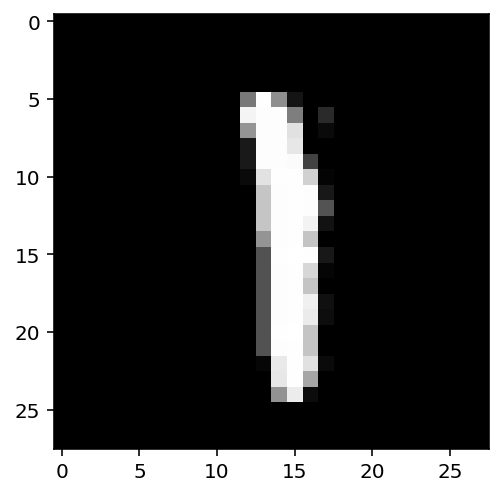

In [34]:
x_image, y_label = next(iter(testloader))

logprobs = my_LR.forward(x_image[0].view(x_image[0].shape[0], -1)) 

# get the top probability and class per image
top_p, top_class = logprobs.topk(1, dim=1)

print(f'The most probable digit for this image is: {top_class.item()}')
plt.imshow(x_image[0].view([28,28]), cmap='Greys_r')

Here I will create an extended class and add this new method that predicts a single image. This is simply a simplification of the overall batch-classifier that was used before.

In [35]:
# adding a method in the class to output the most porbable digit of a single image
class MLP_extended_2(MLP_extended):
    def __init__(self, dimx, hidden1, hidden2, nlabels, epochs=100,lr=0.001):

        super().__init__(dimx, hidden1, hidden2, nlabels, epochs=100,lr=0.001)

        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 

    def predict(self, image):

        logprobs = self.forward(image[0].view(image[0].shape[0], -1)) 
        # get the top probability and class per image
        top_p, top_class = logprobs.topk(1, dim=1)
        print('The loaded image is the following: ')
        plt.imshow(image[0].view([28,28]), cmap='Greys_r')
        print(f'The most probable digit for this image is: {top_class.item()} with probablity: {math.e**(top_p.item())}')



In [36]:
other_MLP = MLP_extended_2(dimx, 124, 64, 10, 5)
other_MLP.train(trainloader)

Training loss after 0 epochs: 0.392014
Training loss after 1 epochs: 0.188357
Training loss after 2 epochs: 0.137305
Training loss after 3 epochs: 0.112669
Training loss after 4 epochs: 0.094480


In [ ]:
x_image, y_label = next(iter(testloader))

The loaded image is the following: 
The most probable digit for this image is: 8 with probablity: 0.9999710329823779


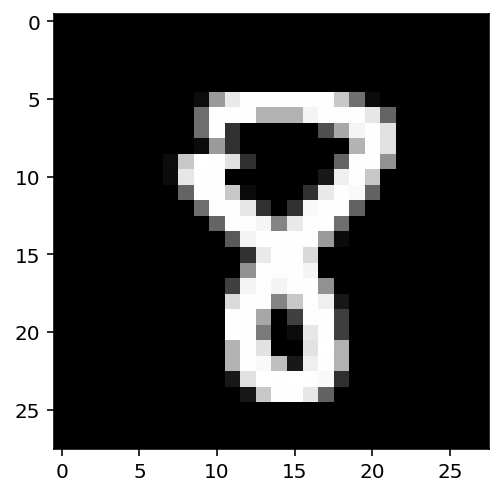

In [38]:
other_MLP.predict(x_image)